In [1]:
from pathlib import Path
from Bio.PDB import PDBParser
from Bio import pairwise2
from Bio.SeqIO import read
import numpy as np
import prody
import shutil
import re
import yaml
import csv
from Bio.SubsMat import MatrixInfo as matlist

from tqdm.auto import tqdm
import torch
import json
import fire
import pandas as pd
from collections import Counter
from Bio import SeqIO

prody.confProDy(verbosity='none')

/home/light/mambaforge/envs/mix/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
def separate_chains(true, pred):
    predict_protein_chain_id = []
    for chain in pred.iterChains():
        if chain.getChid() != "A":  #🌈A
            predict_protein_chain_id.append(chain.getChid())
    predict_pep_chain_id = ["A"]  #🌈A

    chain_length_min = float("inf")
    chains = []
    for chain in true.iterChains():
        chains.append(chain.getChid())
        chain_length = len(list(chain.iterResidues()))
        if chain_length < chain_length_min:
            chain_length_min = chain_length
            true_pep_chain_id = [chain.getChid()]
    true_protein_chain_id = [chain_id for chain_id in chains if chain_id != true_pep_chain_id[0]]  # monomer is []

    return predict_protein_chain_id, predict_pep_chain_id, true_protein_chain_id, true_pep_chain_id

In [3]:
def read_fasta(fasta_file):
    with open(fasta_file, "r") as f:
        record = read(f, "fasta")
        return str(record.seq)

In [4]:
# 蛋白质第一个残基的编号（注意不是残基索引） = predict_{subdir.name}.pdb 中 chain A 的长度 + 1
def get_protein_first_residue_id(chain_atoms):
    for atom in chain_atoms.iterAtoms():
        return atom.getResnum()

In [5]:
def align_sequences(seq_a, seq_b):
    alignments = pairwise2.align.globalms(seq_a, seq_b, 2, -1, -0.5, -0.1)
    best_alignment = alignments[0]
    return best_alignment

In [6]:
def create_score_matrix():
    from Bio.SubsMat import MatrixInfo as matlist
    matrix = matlist.blosum62
    for aa in "ARNDCQEGHILKMFPSTWYV":
        matrix[(aa, 'X')] = 1
        matrix[('X', aa)] = 1
    matrix[('X', 'X')] = 1
    return matrix

In [7]:
def align_sequences_x(seq_a, seq_b):
    matrix = create_score_matrix()
    alignments = pairwise2.align.globalds(seq_a, seq_b, matrix, -0.5, -0.1)
    best_alignment = alignments[0]
    return best_alignment

In [8]:
standard_aa_names = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C', 
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P', 
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

def pdb2fasta(file, protein_chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pdb", file)
    fastas = {}
    ncaa = []
    for id in protein_chain_id:
        fasta_seq = ""
        for residue in structure[0][id]:
            res_name = residue.resname
            if res_name in standard_aa_names:
                fasta_seq += standard_aa_names[res_name]
            else:
                fasta_seq += 'X'
        if "X" in fasta_seq:
            ncaa.append(id)
        fastas[id] = fasta_seq
    return fastas, ncaa

In [9]:
def get_sequence_dict(subdir, true_pdb_dir, true_protein_chain_id):
    fastas = {}
    for fasta_dir in list(subdir.glob("*-protein-*.fasta")):
        fasta = read_fasta(fasta_dir)
        match = re.search(r'-protein-(\d+)\.fasta', str(fasta_dir))
        if match:
            key = match.group(1)
            fastas[key] = fasta  # protein-*.fasta 的字典

    pdb_fasta, _ = pdb2fasta(true_pdb_dir, true_protein_chain_id)  # clean_pdb转为fastas的字典

    sequence_a = fastas  # 字典  predict 键=protein—1的1，值=protein—1的fasta序列
    sequence_b = pdb_fasta  # 字典  true 键=clean_pdb的chain,值=clean_pdb的fasta序列
    return sequence_a, sequence_b

In [10]:
def parse_yaml_to_dict(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)

    protein_dict = {}

    if 'protein_inputs' in data:
        for key, info in data['protein_inputs'].items():
            fasta_file = info.get('fasta_file', '')
            match = re.search(r'-protein-(\d+)\.fasta', fasta_file)
            if match:
                protein_key = match.group(1)
                protein_dict[protein_key] = key
    
    ncaa_num = 0
    if 'sm_inputs' in data:
        for _ in data['sm_inputs']:
            ncaa_num += 1

    return protein_dict, ncaa_num

In [11]:
def gen_mask(sequence_a:dict, sequence_b:dict, yaml_dict:dict):
    scores_dict = {}
    mask_dict = {}
    for key_a, fasta_a in sequence_a.items():
        scores_dict[key_a] = {}
        for key_b, fasta_b in sequence_b.items():
            score = pairwise2.align.globalms(fasta_a, fasta_b, 2, -1, -0.5, -0.1)[0].score
            scores_dict[key_a][key_b] = score

    for key_a, scores in scores_dict.items():
        key_b = max(scores, key=scores.get)
        best_match_seq_a = sequence_a[key_a]
        best_match_seq_b = sequence_b[key_b]
        # alignment = align_sequences(best_match_seq_a, best_match_seq_b)
        alignment = align_sequences_x(best_match_seq_a, best_match_seq_b)
        aligned_seq_a, aligned_seq_b, _, _, _ = alignment

        mask = ['-' not in x for x in zip(aligned_seq_a, aligned_seq_b)]

        mask_dict[yaml_dict[key_a]] = mask

        # mask_dict[key_a] = mask

        # print(f"Pairing: {key_a} (from protein-1/2,...) and {key_b} (from clean_pdb)")
        # print(f"Alignment: \n{pairwise2.format_alignment(*alignment)}")
        # print(f"Mask for alignment between {key_a} and {key_b}: \n{mask}")

    return mask_dict  # 输出的是predict_pdb中的chain id 和 mask 的对应关系。ex.{"B":[True,True,True]}

In [12]:
def processor(true, pred, predict_protein_chain_id, predict_pep_chain_id, mask_dict, ncaa_num):

    pred_pep_atoms = pred.select(f'chain {predict_pep_chain_id[0]}')  # 🌈这边是包括了非标准氨基酸的

    # pred_pep_atoms = pred.select(f'chain {predict_pep_chain_id[0]} and calpha')
    # print("预测pep长度", len(pred_pep_atoms))
    print(mask_dict)

    pred_after_mask = prody.AtomGroup('pred_after_mask')
    first = True
    for id in predict_protein_chain_id:
        pred_protein_atoms = pred.select(f'chain {id}')
        ########################
        # ca_resindices = [atom.getResnum() for atom in pred_protein_atoms if atom.getName() == 'CA'] # 残基编号
        # print("原pred_protein_atoms中的CA索引", ca_resindices)
        ########################
        mask = mask_dict[id]
        protein_first_residue_id = get_protein_first_residue_id(pred_protein_atoms) # 获得残基编号 是pdb里实际可以看到的
        # print(protein_first_residue_id)

        select_str = " ".join([str(idx + protein_first_residue_id) for idx in np.where(mask)[0]])
        #############################
        # print(select_str)
        # select_str_count = len(select_str.split())
        # print(select_str_count)
        #################################


        # pred_protein_atoms = pred_protein_atoms.select(f'resindex {select_str}').toAtomGroup()  # 根据残基索引
        pred_protein_atoms = pred_protein_atoms.select(f'resnum {select_str}').toAtomGroup()  #根据残基编号
        # b = pred_protein_atoms.select('calpha')
        # print("ss", len(b))

        if first:
            coords = pred_protein_atoms.getCoords()
            names = pred_protein_atoms.getNames()
            resnums = pred_protein_atoms.getResnums()
            resnames = pred_protein_atoms.getResnames()
            chids = pred_protein_atoms.getChids()
            first = False
        else:
            coords = np.vstack((coords, pred_protein_atoms.getCoords()))
            names = np.concatenate((names, pred_protein_atoms.getNames()))
            resnums = np.concatenate((resnums, pred_protein_atoms.getResnums()))
            resnames = np.concatenate((resnames, pred_protein_atoms.getResnames()))
            chids = np.concatenate((chids, pred_protein_atoms.getChids()))
    
    coords = np.vstack((coords, pred_pep_atoms.getCoords()))
    names = np.concatenate((names, pred_pep_atoms.getNames()))
    resnums = np.concatenate((resnums, pred_pep_atoms.getResnums()))
    resnames = np.concatenate((resnames, pred_pep_atoms.getResnames()))
    chids = np.concatenate((chids, pred_pep_atoms.getChids()))

    pred_after_mask.setCoords(coords)
    pred_after_mask.setNames(names)
    pred_after_mask.setResnums(resnums)
    pred_after_mask.setResnames(resnames)
    pred_after_mask.setChids(chids)

    return true, pred_after_mask

In [13]:
def select_atoms_by_chains(atom_group, chain_ids:list, atom_name=None, pep = False):
    if not pep:
        if atom_name == "CA":
            if len(chain_ids) == 1:
                selection_str = f"chain {chain_ids[0]} and name CA"  # {atom_name}
            else:
                selection_str = " or ".join([f"chain {chain_id} and name CA" for chain_id in chain_ids]) # name CA
        else:
            if len(chain_ids) == 1:
                selection_str = f"chain {chain_ids[0]}"
            else:
                selection_str = " or ".join([f"chain {chain_id}" for chain_id in chain_ids])
        return atom_group.select(selection_str)
    else:
        if atom_name == "CA":
            selection_str = f"chain {chain_ids[0]} and name CA"
            # selection_str_aa = f"chain {chain_ids[0]} and {atom_name}"
            # selection_str_ncaa = f"chain {chain_ids[0]} and hetero and name CA"
        else:
            selection_str = f"chain {chain_ids[0]}"
            # selection_str_aa = f"chain {chain_ids[0]}"
            # selection_str_ncaa = f"chain {chain_ids[0]} and hetero"
        # print(len(atom_group.select(selection_str_aa)))
        # print(len(atom_group.select(selection_str_ncaa)))
        # a = atom_group.select(selection_str_ncaa)
        # b=[]
        # for i in a:
        #     b.append(i.getResindex())
        # print("b", b)
        return atom_group.select(selection_str)
        # return atom_group.select(selection_str_aa) + atom_group.select(selection_str_ncaa)

In [14]:
standard_amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
                        'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
                        'THR', 'TRP', 'TYR', 'VAL']

In [15]:
def cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align = None, rmsd = None):
    true = prody.parsePDB(str(true_pdb_dir))
    pred = prody.parsePDB(str(predict_pdb_dir))

    predict_protein_chain_id, predict_pep_chain_id, true_protein_chain_id, true_pep_chain_id = separate_chains(true, pred)
    print("预测-蛋白质链",predict_protein_chain_id)
    print("预测-多肽链",predict_pep_chain_id)
    print("真实-蛋白质链",true_protein_chain_id)
    print("真实-多肽链",true_pep_chain_id)

    # if true_protein_chain_id: 
    #     pred_atoms_before = select_atoms_by_chains(pred, predict_protein_chain_id, 'calpha')
    #     print("原pred_pdb总共的蛋白质氨基酸数:", len(pred_atoms_before))

    yaml_dict, ncaa_num  = parse_yaml_to_dict(config) # 键=protein-1/2..., 值= predict_pdb的chain ex.{1:"B"}  单体的话为空字典{}

    if true_protein_chain_id: # 若是复合物，得到 protein-*/fasta 和 clean_pdb's chain id/fasta 的对应蛋白质字典
        sequence_a, sequence_b = get_sequence_dict(subdir, true_pdb_dir, true_protein_chain_id)
        print(sequence_a, sequence_b)
        mask_dict = gen_mask(sequence_a, sequence_b, yaml_dict)  # ex.{"B":[True, False, False]}

        # 测试用 记得删
        # for key, value in mask_dict.items():
        #     print({key: value})
        #     print(len(value))
        
    # if predict_protein_chain_id:  # 如果是复合物
        true, pred = processor(true, pred, predict_protein_chain_id, predict_pep_chain_id, mask_dict, ncaa_num)
        # pred_atoms_after = select_atoms_by_chains(pred, predict_protein_chain_id, 'calpha')
        # print("掩码后pred_pdb总共的蛋白质氨基酸数:", len(pred_atoms_after))

        # if align_protein_chain:
        #     true_atoms = select_atoms_by_chains(true, true_protein_chain_id, 'CA')
        #     pred_atoms = select_atoms_by_chains(pred, predict_protein_chain_id, 'CA')
        # else:
        #     true_atoms = true.select('name CA')
        #     pred_atoms = pred.select('name CA')
        
        if align == "protein":
            true_atoms = select_atoms_by_chains(true, true_protein_chain_id, 'CA')
            pred_atoms = select_atoms_by_chains(pred, predict_protein_chain_id, 'CA')
        elif align == "pep":
            true_atoms = select_atoms_by_chains(true, true_pep_chain_id, 'CA')
            pred_atoms = select_atoms_by_chains(pred, predict_pep_chain_id, 'CA')
        else:
            true_atoms = true.select('name CA')
            pred_atoms = pred.select('name CA')

        # aa = [atom.getResnum() for atom in true_atoms]
        # print("aa", aa)
        # print("原本的true_protein 数：", len(true_atoms))
        # print("对齐后的pred_protein 数：", len(pred_atoms))
    
    else:  # 若为单体
        true_atoms = true.select('name CA')
        pred_atoms = pred.select('name CA')

    ################
    # num = []
    # for atom in true_atoms:
    #     num.append(atom.getResnum())
    # print("true_atoms:", num)
    # print("true_atoms:",len(true_atoms))
    # print("pred_atoms:",len(pred_atoms))
    # a = []
    # for i in true_atoms:
    #     a.append(i.getResindex())
    # print("true_atoms的Resindex:", a)
    # b=0
    # for i in a:
    #     assert b == i, f"{i}"
    #     b+=1
    
    prody.superpose(true_atoms, pred_atoms)

    if rmsd == "hetatm": # 计算ncaa的全原子rmsd
        true_atoms = true.select(f'chain {true_pep_chain_id[0]} and not resname ' + ' '.join(standard_amino_acids) + ' and not hydrogen')
        pred_atoms = pred.select(f'chain {predict_pep_chain_id[0]} and not resname ' + ' '.join(standard_amino_acids))
    elif rmsd == "pep":  # 计算多肽链的CA rmsd
        true_atoms = select_atoms_by_chains(true, true_pep_chain_id, 'CA', pep = True)
        pred_atoms = select_atoms_by_chains(pred, predict_pep_chain_id, 'CA', pep =True)
    else:  # 计算pep的全原子rmsd,但是这个表达式是错的，要排除H
        true_atoms = select_atoms_by_chains(true, true_pep_chain_id, pep = True)
        pred_atoms = select_atoms_by_chains(pred, predict_pep_chain_id, pep = True)
    
    # a=0
    # for i in true_atoms:
    #     a+=1
    #     print(i.getResname(), i.getName())
    # print(a)
    # b=0
    # for i in pred_atoms:
    #     b+=1
    #     print(i.getResname(), i.getName())
    # print(b)
    
    rmsd = prody.calcRMSD(true_atoms, pred_atoms)
    return rmsd

In [16]:
# base_dir = Path("/home/light/mqy/ncaa/data/ncaa/linear/complex")
# for subdir in base_dir.iterdir():
#     if subdir.name == "5otuB":
#         true_pdb_dir = subdir / f"{subdir.name}_clean.pdb"
#         predict_pdb_dir = subdir / f"{subdir.name}.fixed_finetune_192.pdb"
#         config = subdir / f"config_aa.yaml"

#         rmsd_prot_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="protein", rmsd="pep")
#         rmsd_prot_and_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, rmsd="pep")
#         rmsd_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="pep", rmsd="pep")
#         # m_rmsd_prot_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="protein", rmsd="hetatm")
#         # m_rmsd_prot_and_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, rmsd="hetatm")
#         # m_rmsd_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="pep", rmsd="hetatm")

#         # print(f"{subdir.name}'s RMSD: {rmsd_prot_align}, {rmsd_prot_and_pep_align}, {rmsd_pep_align}, {m_rmsd_prot_align}, {m_rmsd_prot_and_pep_align}, {m_rmsd_pep_align}")
#         print(f"{subdir.name}'s RMSD: {rmsd_prot_align}, {rmsd_prot_and_pep_align}, {rmsd_pep_align}")

In [17]:
base_dir = Path("/home/light/mqy/ncaa/data/ncaa/cyc/monomer/head_to_tail")
csv_file = base_dir / "tmp.csv"
        
with open(csv_file, mode='w', newline='') as file:
    fieldnames = ["name", "rmsd(prot align)", "rmsd(prot/pep align)", "rmsd(pep align)", 
                  "modification rmsd(prot align)", "modification rmsd(prot/pep align)", 
                  "modification rmsd(pep align)", "error info"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for subdir in base_dir.iterdir():
        if subdir.is_dir():
            print(subdir.name)
            if "-" in subdir.name:
                continue
            true_pdb_dir = subdir / f"{subdir.name}_clean.pdb"
            predict_pdb_dir = subdir / f"{subdir.name}.fixed.pdb"
            config = subdir / f"config_aa.yaml"
            # try:
            #     rmsd_prot_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="protein", rmsd="pep")
            #     rmsd_prot_and_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, rmsd="pep")
            #     rmsd_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="pep", rmsd="pep")
            #     m_rmsd_prot_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="protein", rmsd="hetatm")
            #     m_rmsd_prot_and_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, rmsd="hetatm")
            #     m_rmsd_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="pep", rmsd="hetatm")
            #     writer.writerow({
            #         "name": subdir.name,
            #         "rmsd(prot align)": f"{rmsd_prot_align:.3f}",
            #         "rmsd(prot/pep align)": f"{rmsd_prot_and_pep_align:.3f}",
            #         "rmsd(pep align)": f"{rmsd_pep_align:.3f}",
            #         "modification rmsd(prot align)": f"{m_rmsd_prot_align:.3f}",
            #         "modification rmsd(prot/pep align)": f"{m_rmsd_prot_and_pep_align:.3f}",
            #         "modification rmsd(pep align)": f"{m_rmsd_pep_align:.3f}",
            #         "error info": ""
            #     })
            # except Exception as e:
            #     writer.writerow({
            #         "name": subdir.name,
            #         "error info": {e}
            #     })

            rmsd_prot_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="protein", rmsd="pep")
            rmsd_prot_and_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, rmsd="pep")
            rmsd_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="pep", rmsd="pep")
            m_rmsd_prot_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="protein", rmsd="hetatm")
            m_rmsd_prot_and_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, rmsd="hetatm")
            m_rmsd_pep_align = cal_rmsd(subdir, true_pdb_dir, predict_pdb_dir, config, align="pep", rmsd="hetatm")
            writer.writerow({
                "name": subdir.name,
                "rmsd(prot align)": f"{rmsd_prot_align:.3f}",
                "rmsd(prot/pep align)": f"{rmsd_prot_and_pep_align:.3f}",
                "rmsd(pep align)": f"{rmsd_pep_align:.3f}",
                "modification rmsd(prot align)": f"{m_rmsd_prot_align:.3f}",
                "modification rmsd(prot/pep align)": f"{m_rmsd_prot_and_pep_align:.3f}",
                "modification rmsd(pep align)": f"{m_rmsd_pep_align:.3f}",
                "error info": ""
            })


2N8E
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
2M2S
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
2KNN
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
2MSQ
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['A']
真实-蛋白质链 []
真实-多肽链 ['A']
预测-蛋白质链 []
预测-多肽链 ['

#### 作图

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
c = "/home/light/mqy/ncaa/data/no_use/ncaa_linear_final_analysis_old/rmsd_results.csv"
df = pd.read_csv(c)
# rmsd_prot_align_data = data['rmsd(prot align)']
# plt.figure(figsize=(10, 6))
# sns.kdeplot(rmsd_prot_align_data, shade=True)
# plt.title('KDE of rmsd(prot align)')
# plt.xlabel('rmsd(prot align)')
# plt.ylabel('Density')
# plt.show()

if 'rmsd(prot align)' not in df.columns:
    raise ValueError("CSV文件中没有名为'mean_plddt'的列")

plt.figure(figsize=(10, 6))
sns.kdeplot(df['rmsd(prot align)'], shade=True, clip=(0, None))
plt.title('KDE of rmsd(prot align)')
plt.xlabel('rmsd(prot align)')
plt.ylabel('Density')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/light/mqy/ncaa/data/no_use/ncaa_linear_final_analysis_old/rmsd_results.csv'

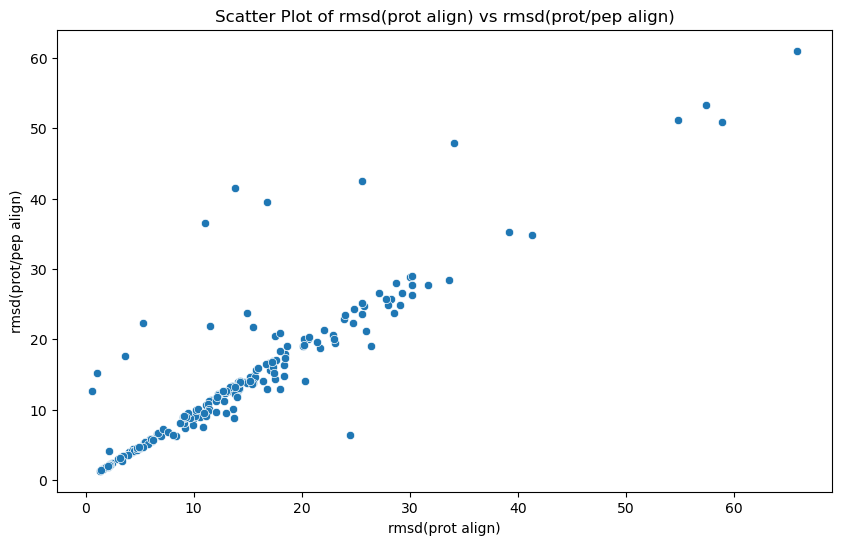

In [ ]:
x_data = df['rmsd(prot align)']
y_data = df['rmsd(prot/pep align)']

# 创建画布并绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_data, y=y_data)
plt.title('Scatter Plot of rmsd(prot align) vs rmsd(prot/pep align)')
plt.xlabel('rmsd(prot align)')
plt.ylabel('rmsd(prot/pep align)')
plt.show()

/tmp/ipykernel_23152/3868395617.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, ax=axes[row, col_idx], clip=(0, None))
/tmp/ipykernel_23152/3868395617.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, ax=axes[row, col_idx], clip=(0, None))
/tmp/ipykernel_23152/3868395617.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, ax=axes[row, col_idx], clip=(0, None))
/tmp/ipykernel_23152/3868395617.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

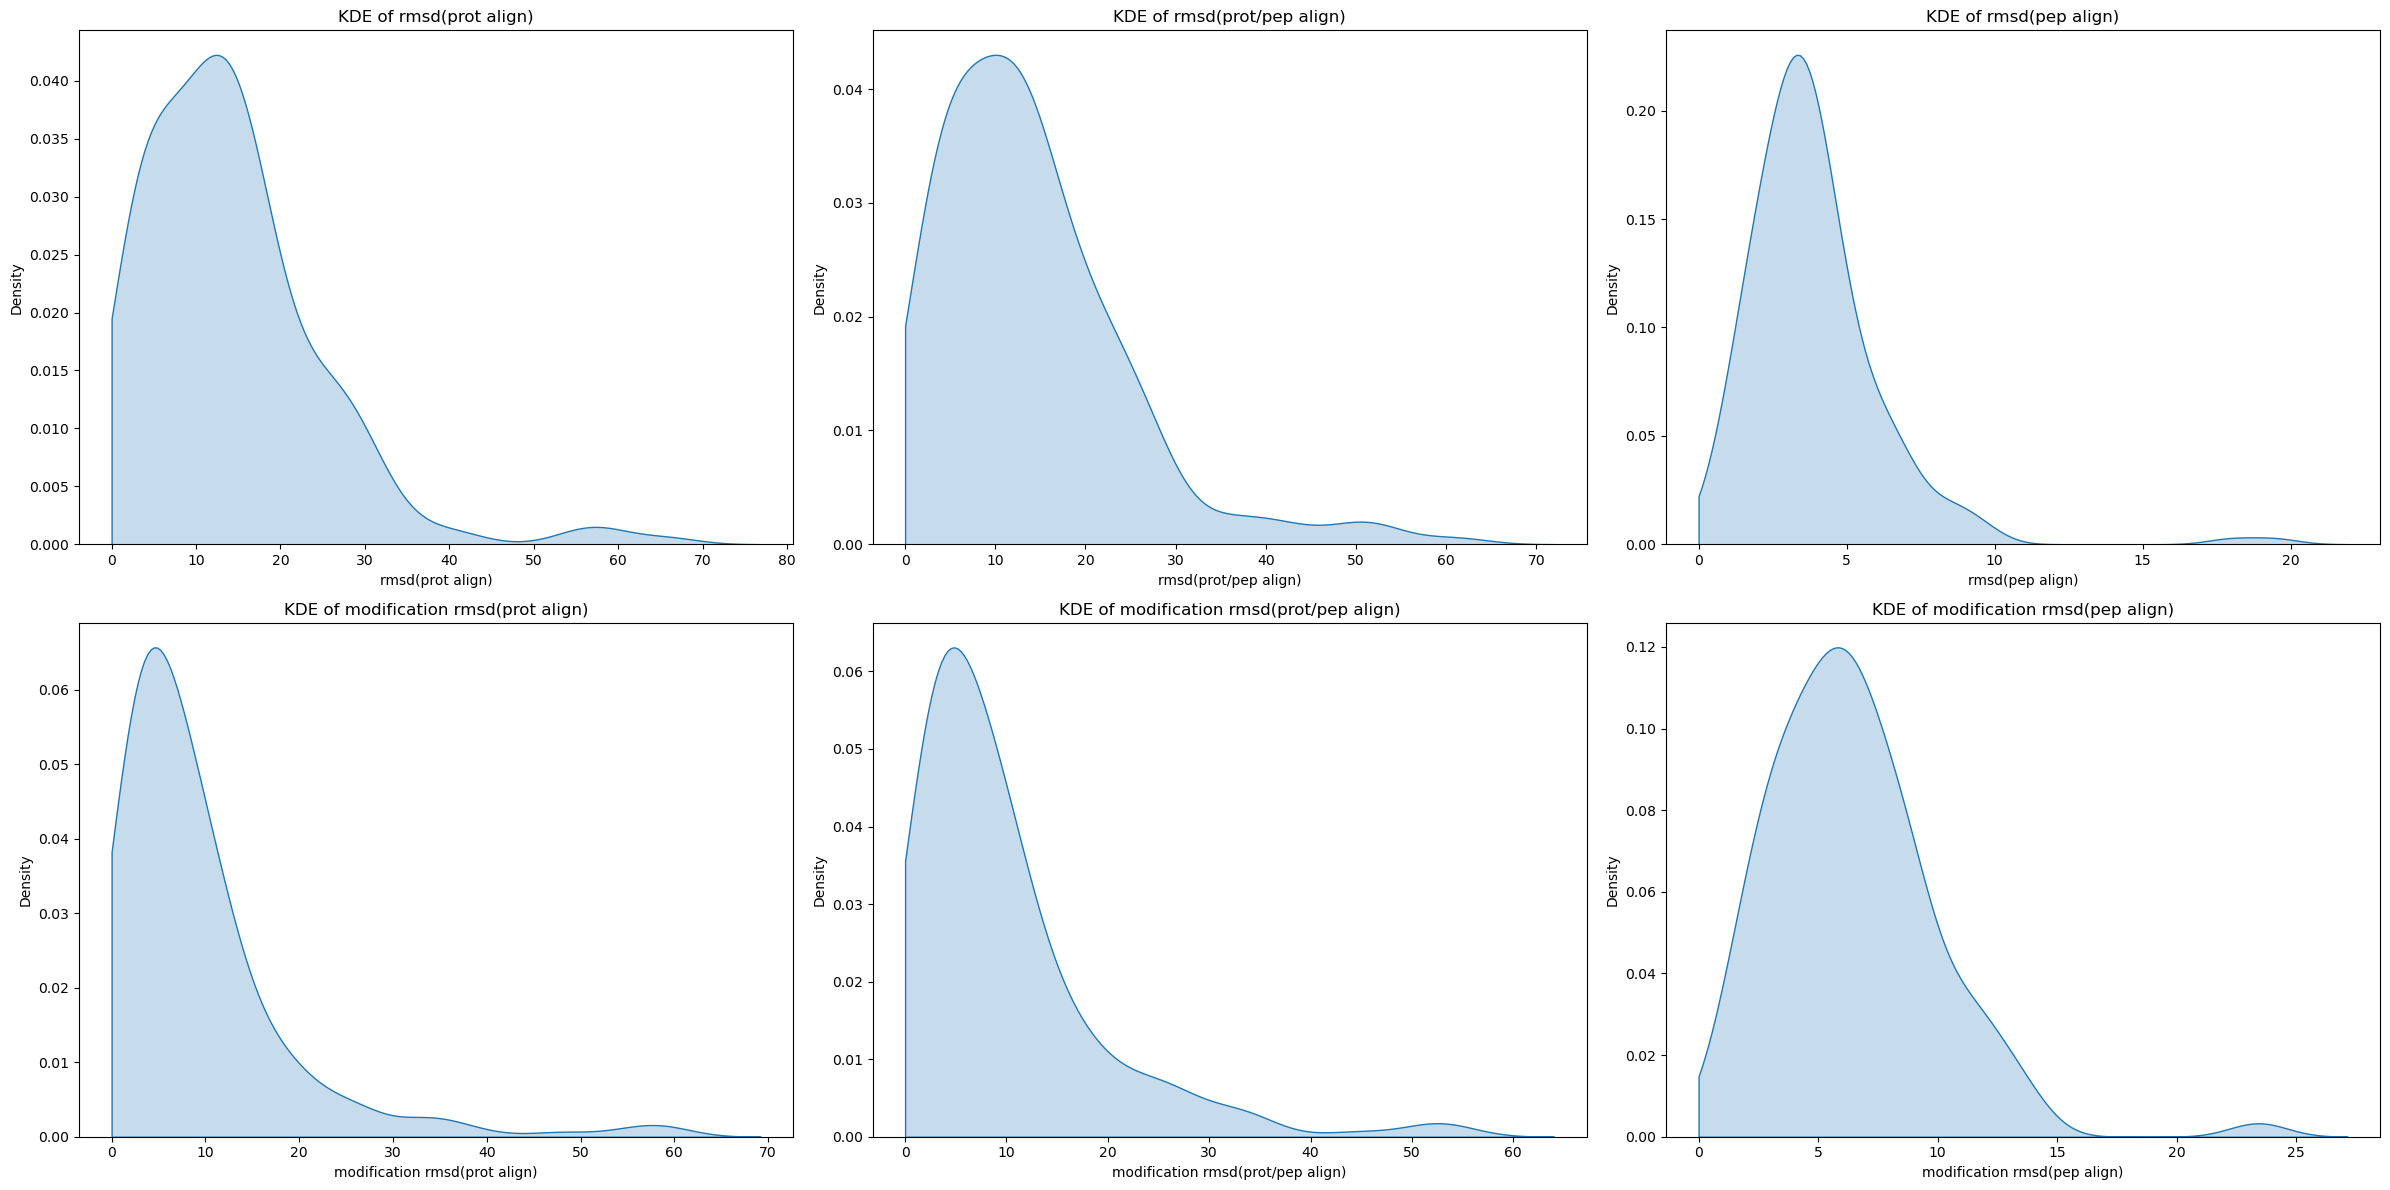

In [ ]:
columns_of_interest = [
    'rmsd(prot align)',
    'rmsd(prot/pep align)',
    'rmsd(pep align)',
    'modification rmsd(prot align)',
    'modification rmsd(prot/pep align)',
    'modification rmsd(pep align)'
]
fig, axes = plt.subplots(2, 3, figsize=(24, 12))  # 创建3行2列的子图

# 绘制六幅KDE图
for i, col in enumerate(columns_of_interest):
    row, col_idx = divmod(i, 3)
    sns.kdeplot(df[col], shade=True, ax=axes[row, col_idx], clip=(0, None))
    axes[row, col_idx].set_title(f'KDE of {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

/tmp/ipykernel_208429/4174422081.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True, color=color, label=col)
/tmp/ipykernel_208429/4174422081.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True, color=color, label=col)
/tmp/ipykernel_208429/4174422081.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True, color=color, label=col)
/tmp/ipykernel_208429/4174422081.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True, 

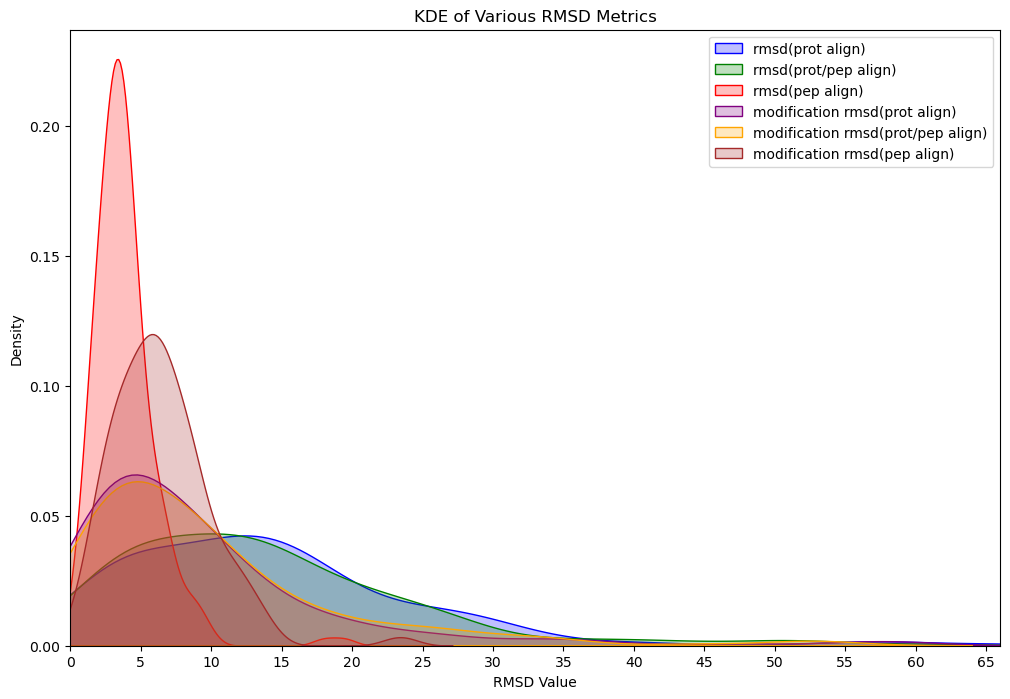

In [ ]:
plt.figure(figsize=(12, 8))

# 颜色列表
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for col, color in zip(columns_of_interest, colors):
    sns.kdeplot(data[col], shade=True, color=color, label=col)

# 设置标题和标签
plt.title('KDE of Various RMSD Metrics')
plt.xlabel('RMSD Value')
plt.ylabel('Density')

max_value = int(data[columns_of_interest].max().max()) + 1
plt.xticks(range(0, max_value + 1, 5))

# 设置x轴的范围，确保0显示在坐标轴上
plt.xlim(0, max_value)

# 添加图例
plt.legend()

# 显示图表
plt.show()